 # 回帰2:客船沈没事故での生存予測

In [59]:
import unittest
import doctest
import os
from domain import CSVRepository, SQLRepository, CategoricalData, DataVisualization, convert_categoricals
import pandas as pd

path = os.path.dirname(os.path.abspath(__file__))
#repo = SQLRepository(table='Survived')
repo = CSVRepository(file= path + '/data/Survived.csv')

 ## データの内容
 | 列名 | 内容 |
 | --- | --- |
 | PassengerId | 乗客ID |
 | Pclass | チケットクラス（1等、2等、3等）|
 | Age | 年齢 |
 | Parch | 同乗した、自身の親と子供の総数 |
 | Fare | 運賃 |
 | Embarked | 搭乗港 |
 | Survived | 1:生存,0:死亡 |
 | Sex | 性別 |
 | SibSp | 同乗した兄弟や配偶者の総数 |
 | Ticket | チケットID |
 | Cabin | 部屋番号 |

In [60]:
df = repo.get_data()
df.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


 ## 問題背景
 客船沈没事故で、どのような人が生き残ったかを分析します。このデータを用いて、客船の乗客の特徴量から生存者を予測するモデルを作成します。

 ## データ分析の方法検討
 - 乗客の特徴から沈没時に生存か死亡かに分類するモデルを作成する。また、その過程で、どのような特徴を持つ人が生き残れたかを考察する。
 - 特徴量を「チケットクラス、年齢、同乗した、自身の親と子供の総数、運賃、搭乗港、性別、同乗した兄弟や配偶者の総数、部屋番号」、目的変数を「生存」（1:生存,0:死亡）として、客船の乗客の生存を予測する。

 分析の実施

 ### データの概要

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


 ### データの統計量

In [62]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


 ### データの特徴量の相関確認

In [63]:
categorical_cols = ['Sex','Ticket','Cabin','Embarked']
df_conv = convert_categoricals(df, categorical_cols)
df_conv.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,1.000000,-0.005007,-0.035144,0.042939,0.036847,-0.057527,-0.001652,-0.056554,0.012658,-0.035077,0.013083
Survived,-0.005007,1.000000,-0.338481,-0.543351,-0.077221,-0.035322,0.081629,-0.164549,0.257307,-0.254888,-0.163517
Pclass,-0.035144,-0.338481,1.000000,0.131900,-0.369226,0.083081,0.018443,0.319869,-0.549500,0.684121,0.157112
Sex,0.042939,-0.543351,0.131900,1.000000,0.093254,-0.114631,-0.245489,0.059372,-0.182333,0.096681,0.104057
Age,0.036847,-0.077221,-0.369226,0.093254,1.000000,-0.308247,-0.189119,-0.075934,0.096067,-0.252331,-0.025252
SibSp,-0.057527,-0.035322,0.083081,-0.114631,-0.308247,1.000000,0.414838,0.079461,0.159651,0.043593,0.066654
Parch,-0.001652,0.081629,0.018443,-0.245489,-0.189119,0.414838,1.000000,0.020003,0.216225,-0.028324,0.038322
Ticket,-0.056554,-0.164549,0.319869,0.059372,-0.075934,0.079461,0.020003,1.000000,-0.013885,0.243696,-0.006041
Fare,0.012658,0.257307,-0.549500,-0.182333,0.096067,0.159651,0.216225,-0.013885,1.000000,-0.503355,-0.221226
Cabin,-0.035077,-0.254888,0.684121,0.096681,-0.252331,0.043593,-0.028324,0.243696,-0.503355,1.000000,0.193205


 ### データの数値変数確認

In [64]:
df.select_dtypes(include='number').columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

 ### データのカテゴリ変数確認

In [65]:
df.select_dtypes(include='object').columns

Index(['Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

 ### 性別カテゴリ

In [66]:
sex = CategoricalData(df, 'Sex')

In [67]:
sex.show()

male      577
female    314
Name: Sex, dtype: int64

<Axes: >

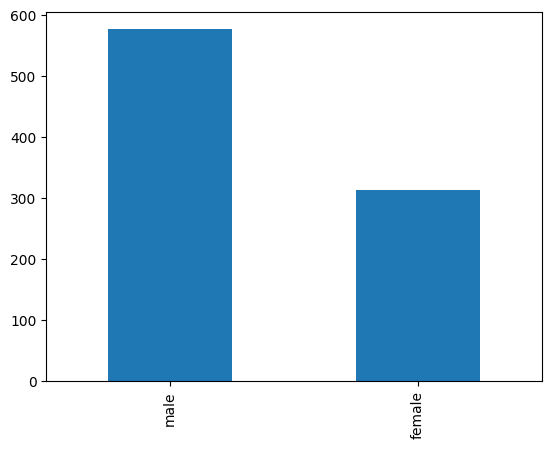

In [68]:
sex.plot()

## %% [markdown]
# ### 種類カテゴリの数値変換

<Axes: >

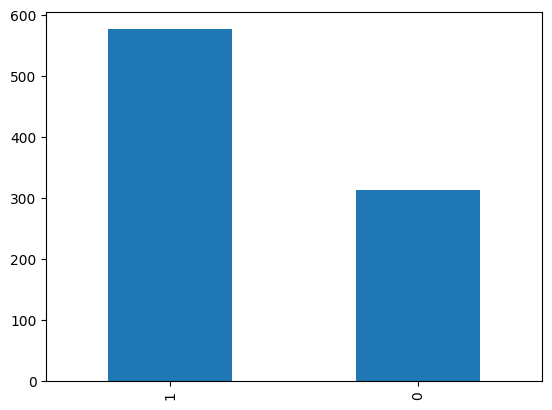

In [69]:
categorical_cols = ['Sex']
df_conv = convert_categoricals(df, categorical_cols)
conv_species = CategoricalData(df_conv, 'Sex')
conv_species.plot()

 ### チケットIDカテゴリ

In [70]:
ticket = CategoricalData(df, 'Ticket')

In [71]:
ticket.show()

347082      7
CA. 2343    7
1601        7
347088      6
3101295     6
           ..
A/5. 851    1
PC 17599    1
367228      1
350050      1
2647        1
Name: Ticket, Length: 681, dtype: int64

<Axes: >

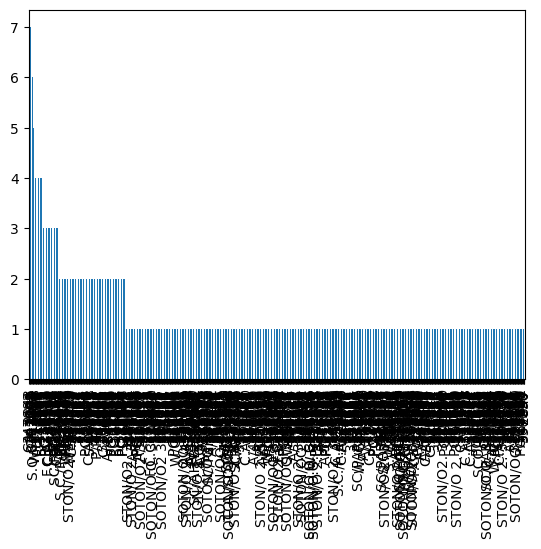

In [72]:
ticket.plot()

## %% [markdown]
# ### 種類カテゴリの数値変換

<Axes: >

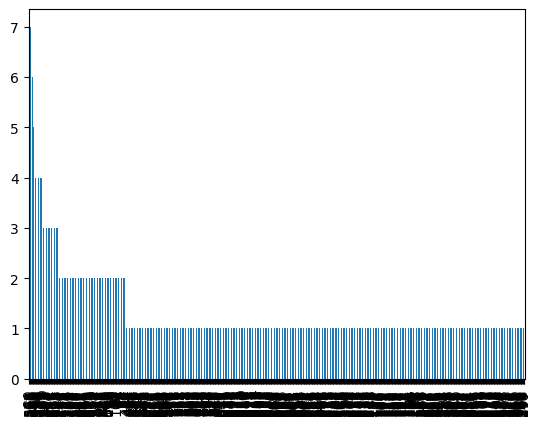

In [73]:
categorical_cols = ['Ticket']
df_conv = convert_categoricals(df, categorical_cols)
conv_species = CategoricalData(df_conv, 'Ticket')
conv_species.plot()

 ### 部屋番号カテゴリ

In [74]:
cabin = CategoricalData(df, 'Cabin')

In [75]:
cabin.show()

B96 B98        4
G6             4
C23 C25 C27    4
F2             3
C22 C26        3
              ..
B82 B84        1
E49            1
B39            1
D50            1
B94            1
Name: Cabin, Length: 147, dtype: int64

<Axes: >

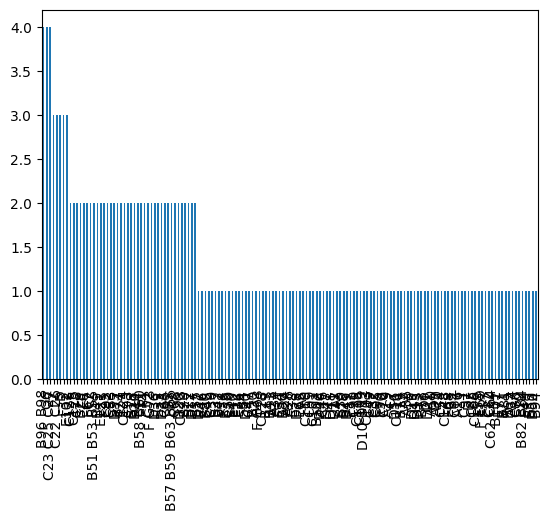

In [76]:
cabin.plot()

## %% [markdown]
# ### 種類カテゴリの数値変換

<Axes: >

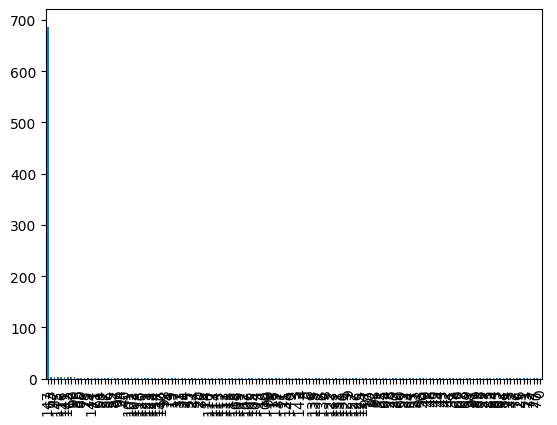

In [77]:
categorical_cols = ['Cabin']
df_conv = convert_categoricals(df, categorical_cols)
conv_species = CategoricalData(df_conv, 'Cabin')
conv_species.plot()

 ### 搭乗港カテゴリ

In [78]:
embarked = CategoricalData(df, 'Embarked')

In [79]:
embarked.show()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

<Axes: >

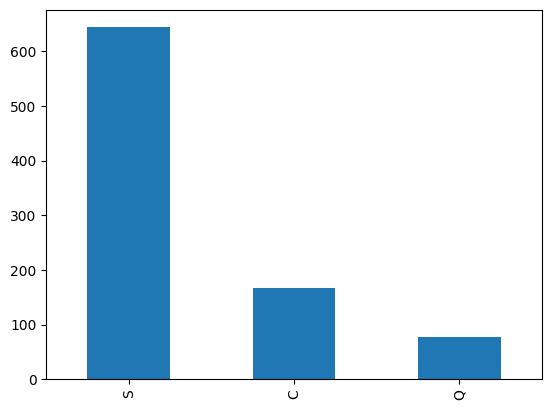

In [80]:
embarked.plot()

## %% [markdown]
# ### 種類カテゴリの数値変換

<Axes: >

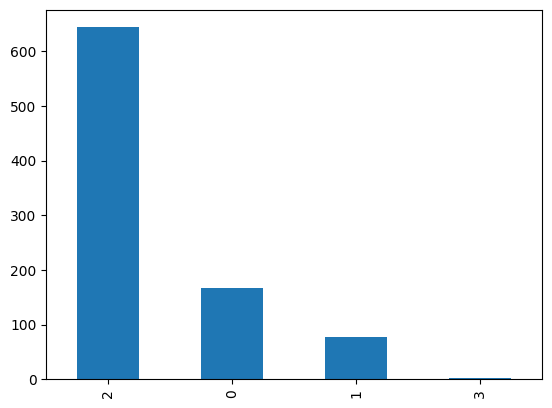

In [81]:
categorical_cols = ['Embarked']
df_conv = convert_categoricals(df, categorical_cols)
conv_species = CategoricalData(df_conv, 'Embarked')
conv_species.plot()

 ### ダミー変数化

In [82]:
df_dummy = pd.get_dummies(df, columns=['Survived'])
df_dummy

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_0,Survived_1
0,1,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0
1,2,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0,1
2,3,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,female,35.0,1,0,113803,53.1000,C123,S,0,1
4,5,3,male,35.0,0,0,373450,8.0500,NaN,S,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,male,27.0,0,0,211536,13.0000,NaN,S,1,0
887,888,1,female,19.0,0,0,112053,30.0000,B42,S,0,1
888,889,3,female,NaN,1,2,W./C. 6607,23.4500,NaN,S,1,0
889,890,1,male,26.0,0,0,111369,30.0000,C148,C,0,1


 ### データの可視化

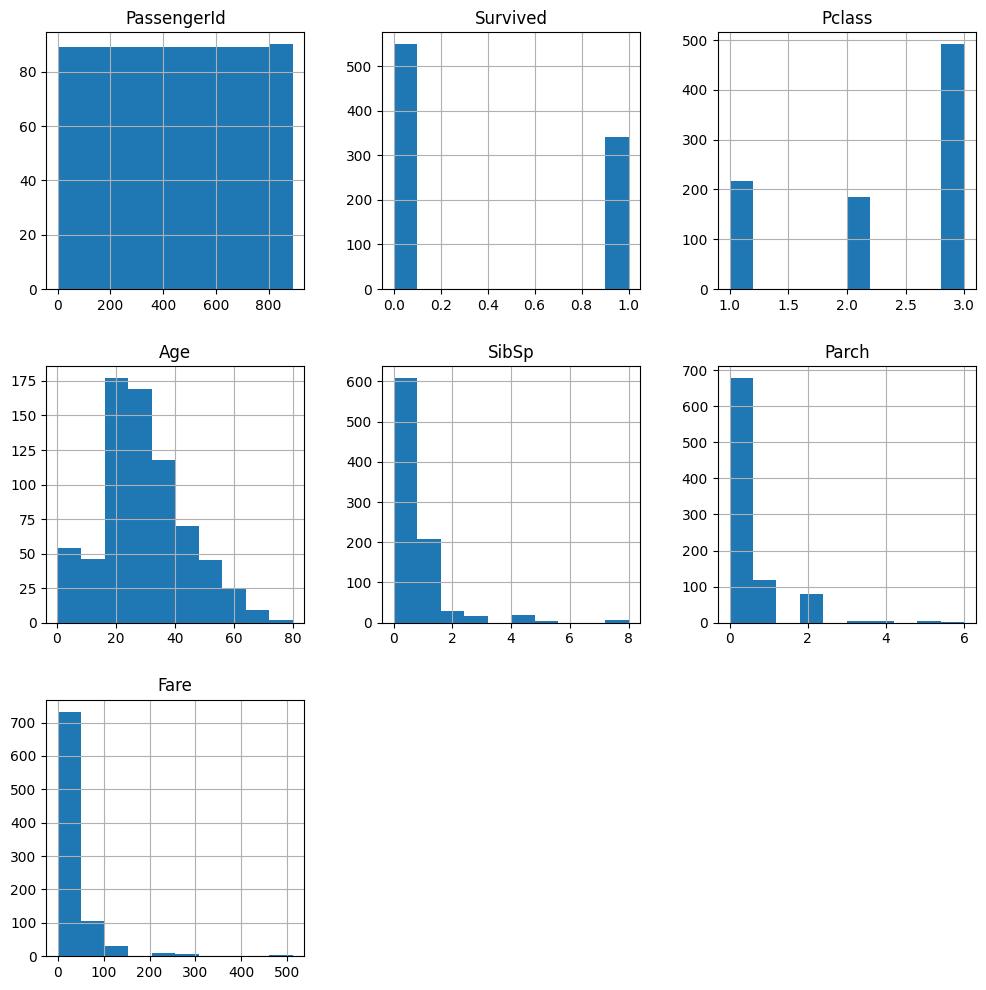

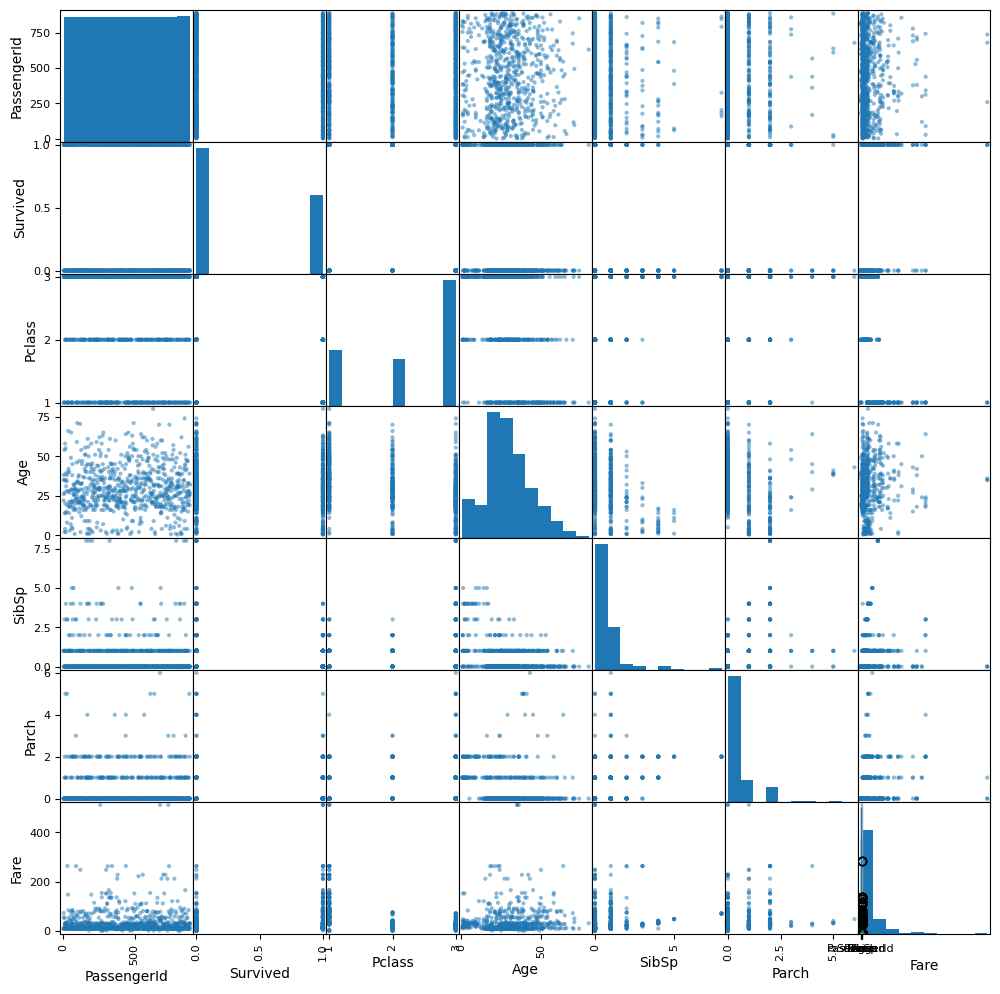

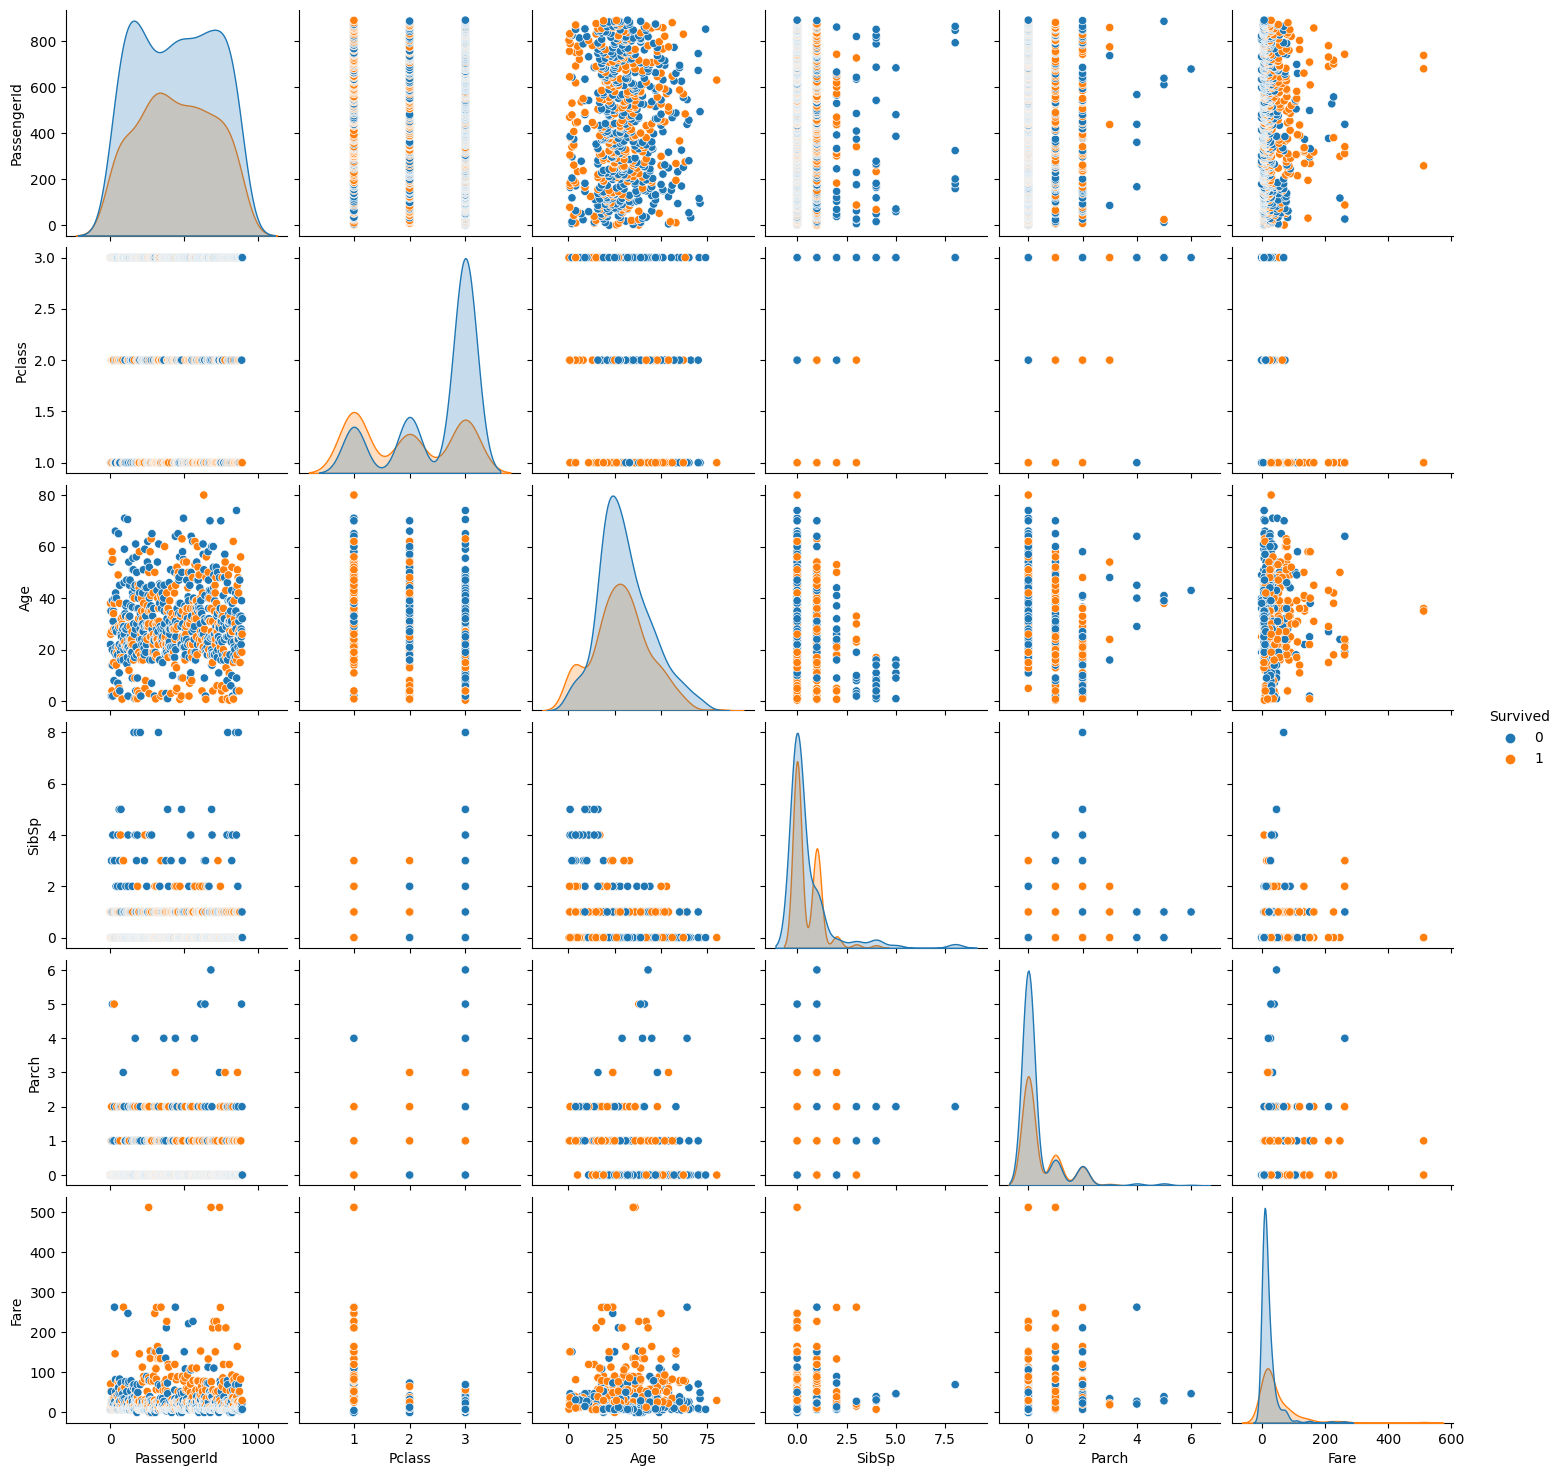

In [83]:
dv = DataVisualization(df)
dv.df_all('Survived')

 ## データの前処理

 ### 欠損地処理（行削除・全体代表値埋め、グループ代表値埋め）

 ### 各手法を必要に応じて実施

 - 外れ値の除外
 - 多項式特徴量・交互作用特徴量の追加
 - 特徴量の絞り込み
 - 標準化

 ## モデルの作成と学習

 ### 未学習状態モデルの生成（分類なら決定木、回帰なら線形回帰）

 ### 訓練データで学習（必要に応じて不均衡データ補正）

 ## モデルの評価

 ### 検証データで評価し指標確認（分類なら正解率、回帰なら決定係数）

 ### NG:改善案検討前処理に戻る
 ### OK:最終性能評価（テストデータで評価）

 ## 決定木における特徴量の考察

In [84]:
doctest.testmod(verbose=True)
unittest.main(argv=[''], verbosity=2, exit=False)

3 items had no tests:
    __main__
    __main__.__VSCODE_compute_hash
    __main__.__VSCODE_wrap_run_cell
0 tests in 3 items.
0 passed and 0 failed.
Test passed.



----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK
